In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
class TimeSeriesForecast():
    def __init__(self, num_points, xmin,xmax):
        self.num_points = num_points
        self.xmin = xmin
        self.xmax = xmax
        self.resolution = (xmax-xmin) / num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_target = np.sin(self.x_data)
        
    def ret_sin(self,x_series):
        return np.sin(x_series)
    def next_batch(self,batch_size,steps,return_ts = False):
        rand_start_index = np.random.rand(batch_size,1)
        ts_start = rand_start_index * (self.xmax - self.xmin - (steps * self.resolution))
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        y_batch  = np.sin(batch_ts)
        if return_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [3]:
ts_data = TimeSeriesForecast(250,0,10)

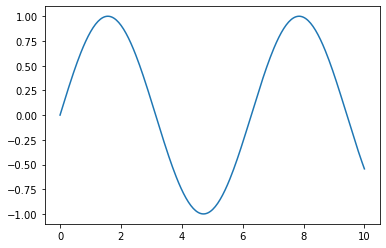

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(ts_data.x_data,ts_data.y_target)

In [95]:
num_steps = 30
y1,y2,ts= ts_data.next_batch(1,num_steps,True)

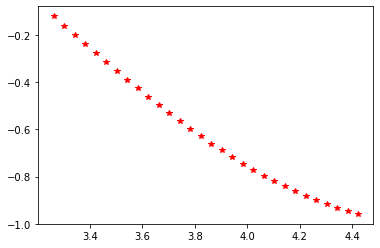

In [96]:
plt.plot(ts.flatten()[1:], y2.flatten(),'*',color='r')

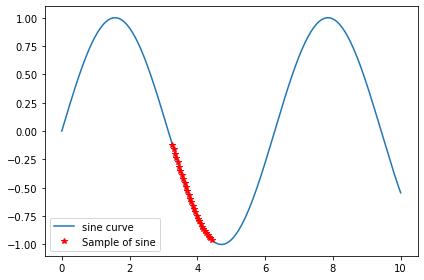

In [121]:
plt.plot(ts_data.x_data,ts_data.y_target, label='sine curve')
plt.plot(ts.flatten()[1:], y2.flatten(),'*',color='r',label = 'Sample of sine')
plt.legend()
plt.tight_layout()
plt.show()

In [98]:
training_inst = np.linspace(5,5+ ts_data.resolution*(num_steps+1) , (num_steps+1))
training_inst.shape

(31,)

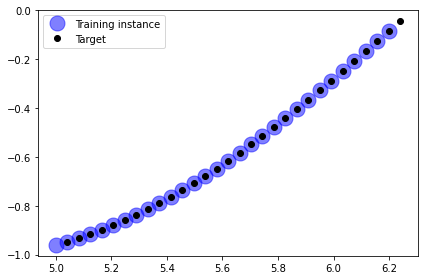

In [99]:
plt.plot(training_inst[:-1],ts_data.ret_sin(training_inst[:-1]), 'bo',markersize = 15,alpha = 0.5, label = 'Training instance')
plt.plot(training_inst[1:],ts_data.ret_sin(training_inst[1:]),'ko',label = 'Target')
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
tf.compat.v1.reset_default_graph()

In [103]:
num_neurons = 7
num_inputs = 1
num_outputs = 1
num_iterations = 1000
batch_size = 1
learning_rate = 0.01

In [104]:
x = tf.compat.v1.placeholder(tf.float32, [None, num_steps,num_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, num_steps,num_outputs])

In [105]:
import tensorflow as tf
rnn = tf.keras.layers.RNN(
    tf.keras.layers.SimpleRNNCell(num_neurons),
    return_sequences=True,
    return_state=True)
output, final_state = rnn(x)
#cell = tf.compat.v1.rnn.OutputProjectionWrapper(cell,output_size = num_outputs)

In [106]:
loss = tf.reduce_mean(tf.square(output-y))

In [107]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(loss)
init = tf.compat.v1.global_variables_initializer()

In [108]:
gpu_opt = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)

In [109]:
saver = tf.compat.v1.train.Saver()

In [110]:
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_opt)) as sess:
    sess.run(init)
    for i in range(num_iterations):
        x_batch,y_batch = ts_data.next_batch(batch_size,num_steps)
        sess.run(train,feed_dict = {x:x_batch, y:y_batch})
        if i % 100 == 0:
            mse_eval = loss.eval(feed_dict = {x:x_batch, y:y_batch})
            print(i,"MSE: ",mse_eval)
    saver.save(sess,"./TimeSeries modelling for Sinewave")

0 MSE:  0.69713527
100 MSE:  0.031792883
200 MSE:  0.021726204
300 MSE:  0.009510449
400 MSE:  0.007568089
500 MSE:  0.012190761
600 MSE:  0.017459158
700 MSE:  0.0062645613
800 MSE:  0.009984789
900 MSE:  0.004074372


In [111]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess,"./TimeSeries modelling for Sinewave")
    x_new_data = np.sin(np.array(training_inst[:-1].reshape(-1,num_steps,num_inputs)))
    y_predict = sess.run(output,feed_dict={x:x_new_data})

INFO:tensorflow:Restoring parameters from ./TimeSeries modelling for Sinewave


In [112]:
#plt.plot(training_inst[:-1],ts_data.ret_sin(training_inst[:-1]), 'bo',markersize = 15,alpha = 0.5, label = 'Training instance')
#plt.plot(training_inst[1:],ts_data.ret_sin(training_inst[1:]),'ko',label = 'Target')

plt.plot(training_inst[1:], y_predict[1,:,0],'r.',  markersize = 15, label = 'RNN prediction')


IndexError: index 1 is out of bounds for axis 0 with size 1

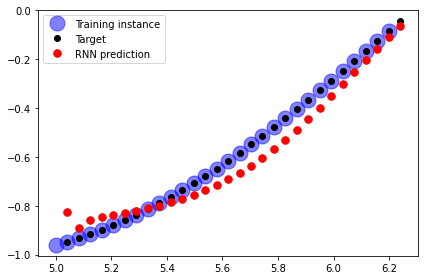

In [113]:
plt.plot(training_inst[:-1],ts_data.ret_sin(training_inst[:-1]), 'bo',markersize = 15,alpha = 0.5, label = 'Training instance')
plt.plot(training_inst[1:],ts_data.ret_sin(training_inst[1:]),'ko',label = 'Target')

plt.plot(training_inst[1:], y_predict[0,:,0],'r.',  markersize = 15, label = 'RNN prediction')

plt.legend()
plt.tight_layout()
plt.show()

In [115]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess,"./TimeSeries modelling for Sinewave")
    training_instance = list(ts_data.y_target[:30])
    for i in range (len(training_instance)-num_steps):
        x_batch = np.array(training_instance[-num_steps:].reshape(1,num_steps,1))
        y_predict_generation = sess.run(output,feed_dict={x:x_batch})
        training_instance.append(y_predict_generation[0:1:0])

INFO:tensorflow:Restoring parameters from ./TimeSeries modelling for Sinewave


No handles with labels found to put in legend.


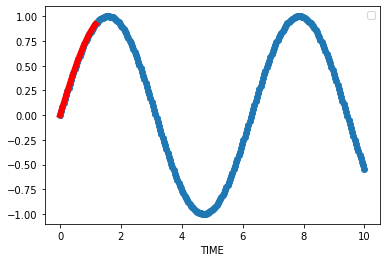

In [120]:
plt.plot(ts_data.x_data, ts_data.y_target,'o')
plt.plot(ts_data.x_data[:num_steps],training_instance[:num_steps],'r-', linewidth = 6)
plt.xlabel('TIME')
plt.legend()
plt.show()